In [12]:
from __future__ import annotations
from typing import TYPE_CHECKING

if TYPE_CHECKING:
    from typing import Literal, TypedDict

    class SentimentConfig(TypedDict):
        use_chi2: bool

#### Import all datasets of All Pulau Kumala's Infrastructures
All datasets will be concated into one single dataframe. It'll be necessary to have same dimension of columns to avoid further data error in processing. All datasets that used with variant total of rows is:
- `dataset_arena_balap_gokart.csv`: 1 rows.
- `dataset_candi_naga_lembuswana.csv`: 1 rows.
- `dataset_dayak_experience_center.csv`: 25 rows.
- `dataset_jembatan_penyebrangan_pulau_kumala.csv`: 1 rows.
- `dataset_kumala_central_park.csv`: 1 rows.
- `dataset_kumala_island.csv`: 1 rows.
- `dataset_patung_lembuswana_area_sps.csv`: 1 rows.
- `dataset_pulau_kumala.csv`: 1 rows.
- `dataaset_sky_tower_kumala.csv`: 1 rows.
- `dataset_taman_air_mancur_pulau_kumala.csv`: 1 rows.
- `dataset_wisata_tenggarong_kolam_naga.csv`: 1 rows.

In [2]:
# import all the necessary modules
import os
import re
import torch
import emoji
from glob import glob
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

d:\suarasiy\skripsi\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# configure the sentiment processing
sentiment_config: SentimentConfig = {
    "use_chi2": False,
}

In [3]:
# Define function for pre-processing

# return None if the review is "[no_review]"
def remove_empty_review (review: str) -> str:
    return None if review == "[no_review]" else review

# remove urls from the text contain urls
def remove_urls (text: str):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

# convert emoji to meaningful text
def convert_emojis (text: str):
    return emoji.demojize(text)

In [4]:
# initialize path to datasets
path_to_datasets = "{}\\datasets".format(os.getcwd())
all_datasets = (pd.read_csv(f) for f in glob(os.path.join(path_to_datasets, "*.csv")))

# concatenate all the datasets
data = pd.concat(all_datasets, ignore_index=True)

# select only columns "review"
data = data[["review"]]

In [5]:
# pre-processing the data

# remove empty reviews by value "[no_review]", then drop the rows with NaN values
data['review'] = data['review'].apply(remove_empty_review)
data = data.dropna(subset=['review'])

# remove urls
data['review'] = data['review'].apply(remove_urls)

# convert emojis
data['review'] = data['review'].apply(convert_emojis)

In [6]:
# tokenize with nlptown/bert-base-multilingual-uncased-sentiment tokenizer and model
tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

# Define function to tokenize the reviews
def predict_sentiment(review: str):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)

    # get the predicted label
    predicted_label = torch.argmax(outputs.logits, dim=1).item()

    return predicted_label

# giving labels to the reviews
data['sentiment'] = data['review'].apply(predict_sentiment)

In [7]:
# Define function to tokenize the reviews
def extract_features(review: str):
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)

    hidden_states = outputs.hidden_states

    # Use the [CLS] token embedding as the sentence embedding
    cls_embedding = hidden_states[-1][:, 0, :].squeeze().numpy()

    return cls_embedding

# extract features from the reviews
data['features'] = data['review'].apply(extract_features)

In [10]:
data.head()

,review,sentiment,features
0,"OK, I have it",2,"[0.021978065, 0.07565795, -0.057591636, -0.515..."
1,The place is good for taking photos,3,"[-0.2428127, -0.61732364, -0.2426435, 0.095686..."
2,A unique and interesting island located in the...,3,"[0.4399781, -0.5964806, -0.17686953, 0.4701182..."
3,One of the tourist destinations on Kumala Isla...,3,"[0.16553363, -0.21731222, -0.16979444, 0.08522..."
4,"Amazing... As a Dayak person, I am very proud ...",4,"[0.5537336, -0.4003766, -0.14024235, -0.071828..."


In [ ]:
# define target features and sentiment labels
X = np.stack(data['features'])
y = data['sentiment']

# scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# perform chi-square feature selection with best K features
selector = SelectKBest(chi2, k=500)
X_selected = selector.fit_transform(X_scaled, y)

Accuracy: 0.8585858585858586
              precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       1.00      0.86      0.92         7
           2       0.73      0.84      0.78        19
           3       0.85      0.85      0.85        40
           4       0.96      0.85      0.90        27

    accuracy                           0.86        99
   macro avg       0.88      0.88      0.88        99
weighted avg       0.87      0.86      0.86        99



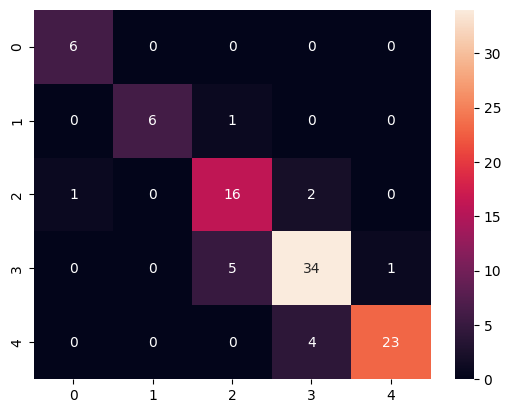

In [ ]:
# check if chi-square feature selection is enabled
if sentiment_config["use_chi2"]:
    X_scaled = X_selected

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# train the model
model = MultinomialNB()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)

# evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

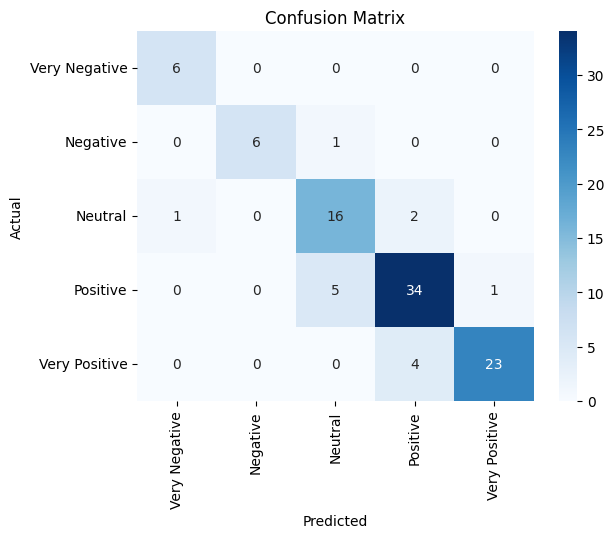

In [18]:
# Define the mapping of sentiment labels to their respective names
sentiment_mapping = {
    0: 'Very Negative',
    1: 'Negative',
    2: 'Neutral',
    3: 'Positive',
    4: 'Very Positive'
}

# Map the sentiment column to their respective names
data['sentiment_label'] = data['sentiment'].map(sentiment_mapping)

# Plot the confusion matrix with sentiment labels
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sentiment_mapping.values(), yticklabels=sentiment_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

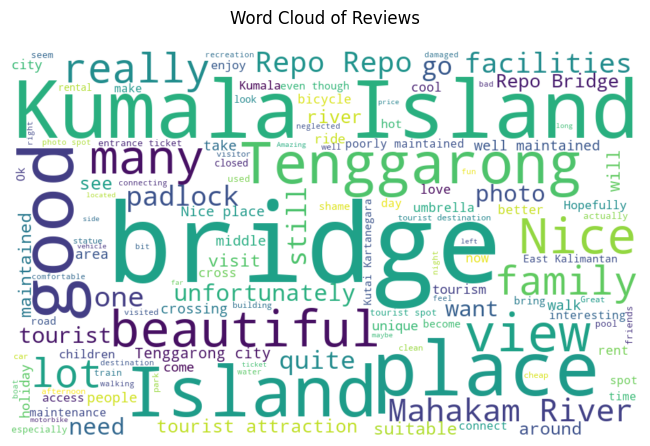

In [26]:
# Combine all reviews into a single string
all_reviews = ' '.join(data['review'])

# Generate the word cloud
wordcloud = WordCloud(width=900, height=550, background_color='white', stopwords=None, min_font_size=10).generate(all_reviews)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews', pad=20)
plt.show()

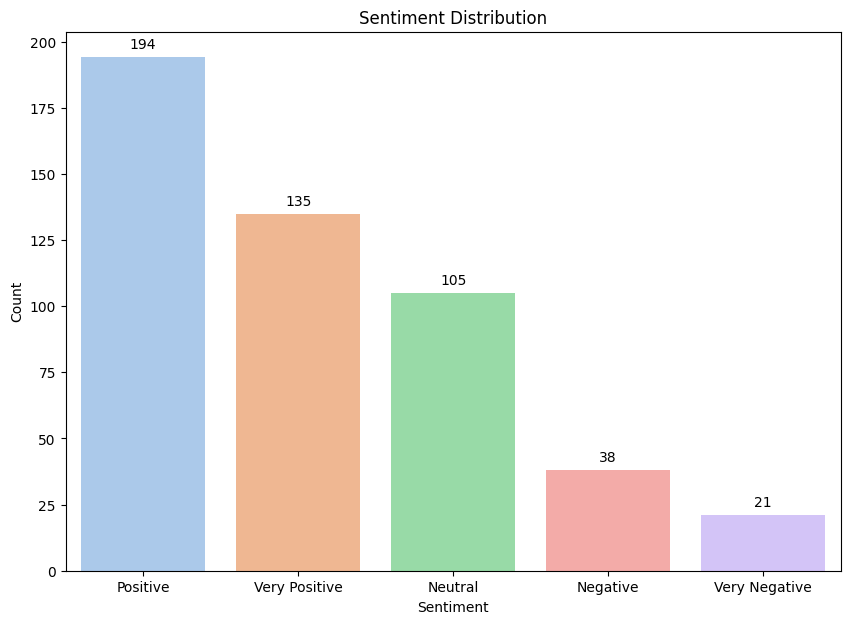

In [50]:
# Count the occurrences of each sentiment label
sentiment_counts = data['sentiment_label'].value_counts()

# Plot the sentiment distribution as a bar chart
plt.figure(figsize=(10, 7))
ax = sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='pastel', hue=sentiment_counts.index)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
# additional save the model

# save the model
# torch.save(model, 'model.pt')

# save the tokenizer
# tokenizer.save_pretrained('tokenizer')

# save the scaler
# torch.save(scaler, 'scaler.pt')

# save the selector
# torch.save(selector, 'selector.pt')

# save the data
# data.to_csv('data.csv', index=False)